In [1]:
import tree_compress
import veritas
import numpy as np
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

noise = 0.05
xtrain, ytrain = make_moons(200, noise=noise, random_state=1)
xtest, ytest = make_moons(200, noise=noise, random_state=2)
xvalid, yvalid = make_moons(200, noise=noise, random_state=3)

data = tree_compress.Data(xtrain, ytrain, xtest, ytest, xvalid, yvalid)

# Training a model on the two moons dataset

In [2]:
clf = RandomForestClassifier(
        max_depth=5,
        random_state=2,
        n_estimators=50)
clf.fit(data.xtrain, data.ytrain)
at_orig = veritas.get_addtree(clf)

# Also train a single decision tree
tree = DecisionTreeClassifier()
tree.fit(data.xtrain, data.ytrain)
at_tree = veritas.get_addtree(tree)

clf, tree

SKLEARN: RF classifier with 1 classes
SKLEARN: single tree classifier with 1 classes


(RandomForestClassifier(max_depth=5, n_estimators=50, random_state=2),
 DecisionTreeClassifier())

# Compress the model using `tree_compress`

In [3]:
at_pruned = tree_compress.compress_topdown(data, at_orig, relerr=0.02, max_rounds=2)

xtrain shape (200, 2)
at nlv 1
MODEL PERF: mtr 1.000 mte 0.990 mva 0.995


ROUND 1
Level 0 xxtrain.shape (200, 51) dense transform time: 0.00s, 0.07s
  1.000   0.995 ->   1.000   1.000,  25% removed (alpha=   0.0026, nnz=38/51) fit ok [1.e-03 1.e+04]
  1.000   0.995 ->   1.000   1.000,  51% removed (alpha=   0.0067, nnz=25/51) fit ok [1.e-03 1.e+04]
  1.000   0.995 ->   1.000   1.000,  63% removed (alpha=   0.0172, nnz=19/51) fit ok [1.e-03 1.e+04]
  1.000   0.995 ->   1.000   1.000,  55% removed (alpha=   0.0444, nnz=23/51) fit ok [1.e-03 1.e+04]
  1.000   0.995 ->   1.000   1.000,  71% removed (alpha=   0.1145, nnz=15/51) fit ok [1.e-03 1.e+04]
  1.000   0.995 ->   1.000   0.995,  78% removed (alpha=   0.2955, nnz=11/51) fit ok [1.e-03 1.e+04]
  1.000   0.995 ->   1.000   1.000,  80% removed (alpha=   0.7627, nnz=10/51) fit ok [1.e-03 1.e+04]
  1.000   0.995 ->   1.000   0.995,  88% removed (alpha=   1.9684, nnz= 6/51) fit ok [1.e-03 1.e+04]
  1.000   0.995 ->   1.000   0.995,  94% r

In [4]:
searches = []
for at in [at_orig, at_pruned, at_tree]:
    config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
    config.stop_when_optimal = False
    search = config.get_search(at)
    
    stop_reason = veritas.StopReason.NONE
    
    while stop_reason != veritas.StopReason.NO_MORE_OPEN:
        stop_reason = search.steps(1000)

    searches.append(search)

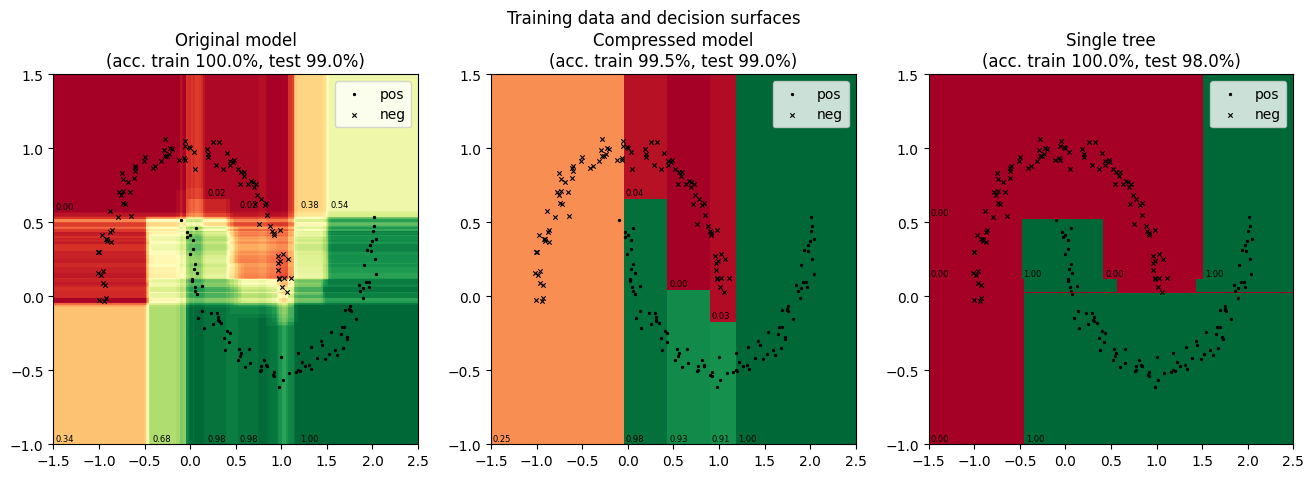

In [5]:
minx, maxx = -1.5, 2.5
miny, maxy = -1.0, 1.5
cmap = plt.colormaps["RdYlGn"]

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
for title, at, search, ax in zip(
    ["Original model", "Compressed model", "Single tree"],
    [at_orig, at_pruned, at_tree],
    searches,
    axs.ravel()
):
    num_sols = search.num_solutions()
    min_output = search.get_solution(num_sols-1).output
    max_output = search.get_solution(0).output
    for i in range(min(10_000, num_sols)):
        sol = search.get_solution(i)
        scaled_output = (sol.output-min_output)/(max_output-min_output)
        box = sol.box()
        ival0 = box.get(0, veritas.Interval())
        ival1 = box.get(1, veritas.Interval())
        x0 = max(minx, ival0.lo)
        y0 = max(miny, ival1.lo)
        x1 = min(maxx, ival0.hi)
        y1 = min(maxy, ival1.hi)
        w, h = x1-x0, y1-y0
        rect = plt.Rectangle((x0, y0), w, h,
                             fc=cmap(scaled_output),
                             lw=0.0, ec="black")

        ax.add_patch(rect)
        if w > 0.15 and h > 0.10:
            ax.text(x0+0.02, y0+0.01, f"{scaled_output:.2f}",
                   fontsize=6, ha="left", va="bottom")

    ax.scatter(xtrain[ytrain==1, 0], xtrain[ytrain==1, 1], marker='.', c="black", s=10, linewidths=0.8, label="pos")
    ax.scatter(xtrain[ytrain==0, 0], xtrain[ytrain==0, 1], marker='x', c="black", s=10, linewidths=0.8, label="neg")
    #ax.scatter(xtest[ytest==1, 0], xtest[ytest==1, 1], marker='.', c="black", s=10)
    #ax.scatter(xtest[ytest==0, 0], xtest[ytest==0, 1], marker='x', c="black", s=10, linewidths=0.8)
    #ax.plot(xvalid[yvalid==1, 0], xvalid[yvalid==1, 1], '*')
    #ax.plot(xvalid[yvalid==1, 0], xvalid[yvalid==1, 1], '*')

    ax.legend()

    acc_train = np.mean((at.predict(xtrain)[:,0] > 0.5).astype(int)== ytrain)
    acc_test = np.mean((at.predict(xtest)[:,0] > 0.5).astype(int)== ytest)
    ax.set_title(f"{title}\n(acc. train {acc_train*100:.1f}%, test {acc_test*100:.1f}%)")
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])

fig.suptitle("Training data and decision surfaces")
fig.subplots_adjust(top=0.85)
plt.show()